In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import copy
from utils import *
from scipy import signal
from scipy.sparse import linalg
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix
from scipy.sparse import save_npz

In [2]:
def line_intersect(a1, a2, b1, b2):
    line1 = a2 - a1
    line2 = b2 - b1
    dab = a1 - b1
    dap = np.zeros(line1.shape)
    dap[0], dap[1] = -line1[1], line1[0]
    denom = np.dot(dap, line2)
    num = np.dot(dap, dab)
    return (num / denom)*line2 + b1

def define_coords(xs, ys, height, width, loc):
    if (loc == 0):
        # top left
        a1 = np.array([xs[1], abs(height - ys[1])])
        a2 = np.array([xs[0], abs(height - ys[0])])
        b1 = np.array([0, 0])
        b2 = np.array([0, height])
    elif (loc == 1):
        # top right
        a1 = np.array([xs[1], abs(height - ys[1])])
        a2 = np.array([xs[2], abs(height - ys[0])])
        b1 = np.array([width, 0])
        b2 = np.array([width, height])
    elif (loc == 2):
        # bottom left
        a1 = np.array([xs[1], abs(height - ys[1])])
        a2 = np.array([xs[0], abs(height - ys[2])])
        b1 = np.array([0, 0])
        b2 = np.array([0, height])
    elif (loc == 3):
        # bottom right
        a1 = np.array([xs[1], abs(height - ys[1])])
        a2 = np.array([xs[2], abs(height - ys[2])])
        b1 = np.array([width, 0])
        b2 = np.array([width, height])
    elif (loc == 4):
        # P2 - P0 / P0 - P1
        a1 = np.array([xs[1], abs(height - ys[1])])
        a2 = np.array([xs[0], abs(height - ys[0])])
        b1 = np.array([0, height])
        b2 = np.array([width, height])
    elif (loc == 5):
        # P3 - P1 / P0 - P1
        a1 = np.array([xs[1], abs(height - ys[1])])
        a2 = np.array([xs[2], abs(height - ys[0])])
        b1 = np.array([0, height])
        b2 = np.array([width, height])
    elif (loc == 6):
        # P5 - P7 / P6 - P7
        a1 = np.array([xs[1], abs(height - ys[1])])
        a2 = np.array([xs[2], abs(height - ys[2])])
        b1 = np.array([0, 0])
        b2 = np.array([width, 0])
    elif (loc == 7):
        # P4 - P6 / P6 - P7
        a1 = np.array([xs[1], abs(height - ys[1])])
        a2 = np.array([xs[0], abs(height - ys[2])])
        b1 = np.array([0, 0])
        b2 = np.array([width, 0])
    
    res = line_intersect(a1,a2,b1,b2)
    res[1] = height - res[1]
    return (int(res[0]), int(res[1]))

def display_box(coords, img):
    image = copy.deepcopy(img)
    xs, ys = [int(i) for i in coords[0]], [int(i) for i in coords[1]]
    coord1, coord2, coord3, coord4 = (xs[0],ys[0]), (xs[2],ys[0]), (xs[0],ys[2]), (xs[2],ys[2])
    color = (255, 0, 0) 
    thickness = 5
    cv2.line(image, coord1, coord2, color, thickness)
    cv2.line(image, coord2, coord4, color, thickness)
    cv2.line(image, coord4, coord3, color, thickness)
    cv2.line(image, coord3, coord1, color, thickness)
    
    height, width = image.shape[0], image.shape[1]
    
    top_left =  define_coords(xs, ys, height, width, 0)
    bottom_left = define_coords(xs, ys, height, width, 2)
    cv2.line(image, coord1, top_left, color, thickness)
    cv2.line(image, coord3, bottom_left, color, thickness)
    
    top_right =  define_coords(xs, ys, height, width, 1)
    bottom_right = define_coords(xs, ys, height, width, 3)
    cv2.line(image, coord2, top_right, color, 3)
    cv2.line(image, coord4, bottom_right, color, 3)
    
    plt.figure()
    plt.imshow(image)
    return image

def save_img(img, filename):
    plt.imsave(filename, img)

def makeCoords3D(xs, ys, x_multiplier, height, depth):
    P0 = ((xs[0]-xs[1])*x_multiplier, height, 0)
    P1 = ((xs[2]-xs[1])*x_multiplier, height, 0)
    P2 = ((xs[0]-xs[1])*x_multiplier, height, depth)
    P3 = ((xs[2]-xs[1])*x_multiplier, height, depth)
    P4 = ((xs[0]-xs[1])*x_multiplier, 0, depth)
    P5 = ((xs[2]-xs[1])*x_multiplier, 0, depth)
    P6 = ((xs[0]-xs[1])*x_multiplier, 0, 0)
    P7 = ((xs[2]-xs[1])*x_multiplier, 0, 0)
    return [P0,P1,P2,P3,P4,P5,P6,P7]

def homography(img, xs, ys, loc):
    height, width = img.shape[0], img.shape[1]
    uvCoords = np.array([[0.,0.], [256.,0.], [0.,256.], [256.,256.]])
    if (loc == 'left'):
        res = define_coords(xs, ys, height, width, 0) # top left coords
        res2 = define_coords(xs, ys, height, width, 2) # bottom left coords
        # P0, P2, P6, P4
        a = np.array([res[1], res[0]])
        b = np.array([ys[0], xs[0]])
        c = np.array([res2[1], res2[0]])
        d = np.array([ys[2], xs[0]])
    elif (loc == 'right'):
        res = define_coords(xs, ys, height, width, 1) # top right coords
        res2 = define_coords(xs, ys, height, width, 3) # bottom right coords
        # P3, P5, P1, P7
        a = np.array([ys[0], xs[2]])
        b = np.array([ys[2], xs[2]])
        c = np.array([res[1], res[0]])
        d = np.array([res2[1], res2[0]])
    elif (loc == 'top'):
        res = define_coords(xs, ys, height, width, 4)
        res2 = define_coords(xs, ys, height, width, 5)
        # P0, P1, P2, P3
        a = np.array([res[1], res[0]])
        b = np.array([res2[1], res2[0]])
        c = np.array([ys[0], xs[0]])
        d = np.array([ys[0], xs[2]])
    elif (loc == 'bottom'):
        res = define_coords(xs, ys, height, width, 6)
        res2 = define_coords(xs, ys, height, width, 7)
        # P4, P6, P5, P7
        a = np.array([ys[2], xs[0]])
        b = np.array([ys[2], xs[2]])
        c = np.array([res2[1], res2[0]])
        d = np.array([res[1], res[0]])

    picCoords = np.array([[a[1],a[0]], [b[1],b[0]], [c[1],c[0]], [d[1],d[0]]])
    H, _ = cv2.findHomography(picCoords, uvCoords)
    return H

In [ ]:
def construct(coords, folder, img, focal_len):
    xs, ys = [int(i) for i in coords[0]], [int(i) for i in coords[1]]

    # back wall
    back = cv2.resize(img[ys[0]:ys[2], xs[0]:xs[2]], (256,256), interpolation = cv2.INTER_AREA)
    save_img(back, folder+'/back.jpeg')

    H = homography(img, xs, ys, 'left')
    left = cv2.warpPerspective(img, H, (256,256))
    plt.imsave(folder+'/left.jpeg', left)
    
    H = homography(img, xs, ys, 'right')
    right = cv2.rotate(cv2.flip(cv2.warpPerspective(img, H, (256,256)), 0), cv2.ROTATE_90_CLOCKWISE)
    plt.imsave(folder+'/right.jpeg', right)
    
    H = homography(img, xs, ys, 'top')
    top = cv2.warpPerspective(img, H, (256,256))
    plt.imsave(folder+'/top.jpeg', top)
    
    H = homography(img, xs, ys, 'bottom')
    bottom = cv2.warpPerspective(img, H, (256,256))
    plt.imsave(folder+'/bottom.jpeg', bottom)
    
    fig, axes = plt.subplots(1, 5, figsize=(15, 15))
    axes[0].imshow(back)
    axes[1].imshow(left)
    axes[2].imshow(right)
    axes[3].imshow(top)
    axes[4].imshow(bottom)
    plt.tight_layout()
    
    height = (ys[2]-ys[0]) / (ys[2]-ys[1])
    x_multiplier = 1 / (ys[2]-ys[1])
    depth = -focal_len / (ys[2]-ys[1])
    coords3D = makeCoords3D(xs, ys, x_multiplier, height, depth)
    save_obj(coords3D[4],coords3D[5],coords3D[2],coords3D[3], 'back', folder)
    save_obj(coords3D[6],coords3D[4],coords3D[0],coords3D[2], 'left', folder)
    save_obj(coords3D[5],coords3D[7],coords3D[3],coords3D[1], 'right', folder)
    save_obj(coords3D[6],coords3D[7],coords3D[4],coords3D[5], 'bottom', folder)
    save_obj(coords3D[2],coords3D[3],coords3D[0],coords3D[1], 'top', folder)
    
    return coords3D, x_multiplier, depth

In [41]:
def construct_foreground(img, coords, f_coords, mask_fg_ground_coords, folder, coords3D, focal_len, x_multiplier, depth):
    xs, ys = [int(i[0]) for i in f_coords], [int(i[1]) for i in f_coords]
    world_xs, world_ys = [int(i) for i in coords[0]], [int(i) for i in coords[1]]

    height=(ys[-1]-xs[0])*x_multiplier
    depth_ratio = ((world_ys[2]-world_ys[1])/(ys[1]-world_ys[1])) * ((ys[0]-world_ys[1])/(ys[1]-world_ys[1]))   
    depth = depth_ratio * depth
    
    bottom_left=np.array([(xs[0]-world_xs[1])*x_multiplier, 0, depth])
    bottom_right=np.array([(xs[3]-world_xs[1])*x_multiplier, 0, depth])
    top_left=np.array([(xs[0]-world_xs[1])*x_multiplier, height, depth])
    top_right = np.array([(xs[3]-world_xs[1])*x_multiplier, height, depth])
    
    #img[np.where(img==1)] = np.nan
    #fig = plt.figure()
    #plt.imshow(img)

    # save figure with transparent=True argument
    #plt.savefig(folder+'/fgobj.jpeg', transparent=True)
    save_img(img, folder+'/fgobj.jpeg')
    save_obj(bottom_left, bottom_right, top_left, top_right, 'fgobj', folder)

In [57]:
# Blender object export
def save_obj(a, b, c, d, filename, folder):
    obj = "mtllib" + " " + filename+".mtl\n" + "o Plane\n"
    for i in [a, b, c, d]:
        obj += "v" + " " + str(i[0]) + " " + str(i[1]) + " " + str(i[2]) + "\n"
    for j in [(0,0), (1,0), (0,1), (1,1)]:
        obj += "vt" + " " + str(j[0]) + " " + str(j[1]) + "\n"
    
    obj += "usemtl " + filename+"Material\n"
    obj +="s off\n"
    obj += "f 1/1/1 2/2/1 4/4/1 3/3/1\n"
                
    mlt = "newmtl " + filename+"Material\n" +  "map_Kd " + filename+".jpeg\n" + "map_Ka " + filename+".jpeg"
    file = open(folder+'/'+filename+'.obj', 'w')
    file.write(obj)
    file.close()
    
    file = open(folder+'/'+filename+'.mtl', 'w')
    file.write(mlt)
    file.close()

## Example 1 with foreground

If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


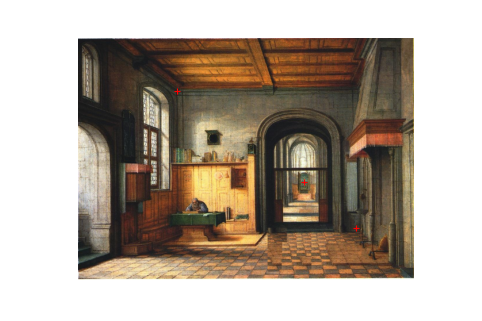

In [40]:
filename = 'images/1.jpg'
img = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB).astype('double') / 255.0 

import matplotlib.pyplot as plt
%matplotlib notebook
coords = specify_mask(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


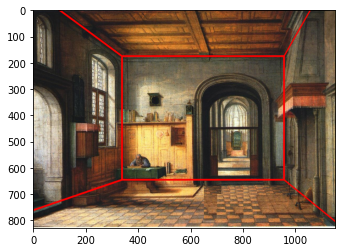

In [5]:
%matplotlib inline
display = display_box(coords, img)

mtllib back.mtl
o Plane
v -2.9060402684563758 0 -6.7114093959731544
v 1.2281879194630871 0 -6.7114093959731544
v -2.9060402684563758 3.1543624161073827 -6.7114093959731544
v 1.2281879194630871 3.1543624161073827 -6.7114093959731544
vt 0.000000 0.000000
vt 1.000000 0.000000
vt 0.000000 1.000000
vt 1.000000 1.000000
usemtl backMaterial
s off
f 1/1/1 2/2/1 4/4/1 3/3/1
mtllib left.mtl
o Plane
v -2.9060402684563758 0 0
v -2.9060402684563758 0 -6.7114093959731544
v -2.9060402684563758 3.1543624161073827 0
v -2.9060402684563758 3.1543624161073827 -6.7114093959731544
vt 0.000000 0.000000
vt 1.000000 0.000000
vt 0.000000 1.000000
vt 1.000000 1.000000
usemtl leftMaterial
s off
f 1/1/1 2/2/1 4/4/1 3/3/1
mtllib right.mtl
o Plane
v 1.2281879194630871 0 -6.7114093959731544
v 1.2281879194630871 0 0
v 1.2281879194630871 3.1543624161073827 -6.7114093959731544
v 1.2281879194630871 3.1543624161073827 0
vt 0.000000 0.000000
vt 1.000000 0.000000
vt 0.000000 1.000000
vt 1.000000 1.000000
usemtl rightMateria

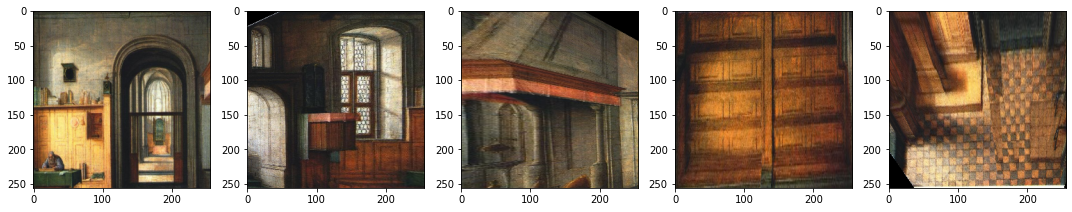

In [6]:
coords3D, x_multiplier, depth = construct(coords, 'results/1', img, 1000)

In [26]:
filename = 'results/foreground.jpg'
foreground = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
#foreground = cv2.resize(foreground, (256,256), interpolation = cv2.INTER_AREA)
foreground.shape

(150, 150, 3)

In [27]:
def foreground_coords(img, bottom_right=(800,800)):
    height, width = img.shape[0], img.shape[1]
    top_left = (bottom_right[0]-height, bottom_right[1]-width)
    top_right = (bottom_right[0]-height, bottom_right[1])
    bottom_left = (bottom_right[0], bottom_right[1]-width)
    return (top_left, top_right, bottom_left, bottom_right)

In [28]:
f_coords = foreground_coords(foreground)
f_coords

((650, 650), (650, 800), (800, 650), (800, 800))

In [30]:
construct_foreground(foreground, coords, f_coords, (f_coords[2], f_coords[3]), 'results/1', coords3D, 1000, x_multiplier, depth)

mtllib fgobj.mtl
o Plane
v -0.8120805369127516 0.0 -1.6663781163434903
v 0.19463087248322147 0.0 -1.6663781163434903
v -0.8120805369127516 1.006711409395973 -1.6663781163434903
v 0.19463087248322147 1.006711409395973 -1.6663781163434903
vt 0.000000 0.000000
vt 1.000000 0.000000
vt 0.000000 1.000000
vt 1.000000 1.000000
usemtl fgobjMaterial
s off
f 1/1/1 2/2/1 4/4/1 3/3/1


## Example 2 without foreground

If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


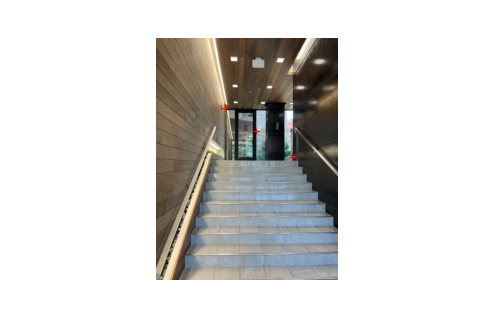

In [64]:
filename = 'images/2.jpg'
img = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB).astype('double') / 256.0 

import matplotlib.pyplot as plt
%matplotlib notebook
coords = specify_mask(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


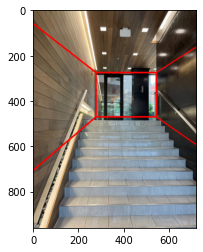

In [65]:
%matplotlib inline
display = display_box(coords, img)

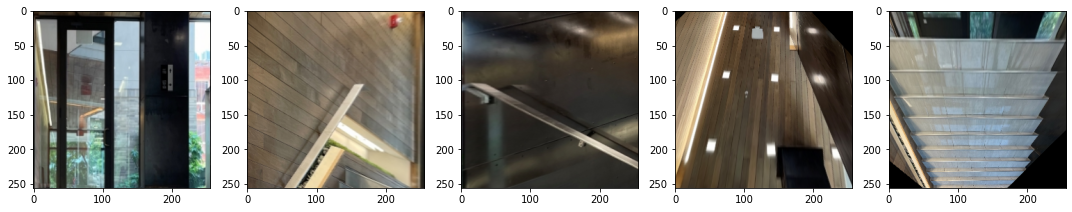

In [66]:
coords3D, x_multiplier, depth = construct(coords, 'results/2', img, 1000)

## Example 2 without foreground

If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


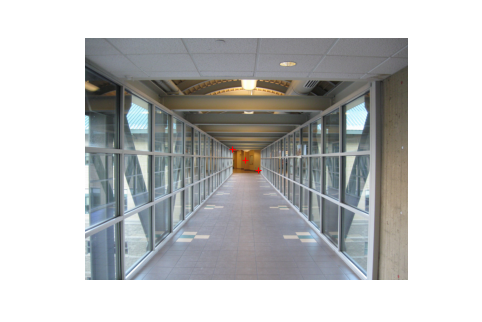

In [60]:
filename = 'images/3.jpg'
img = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB).astype('double') / 256.0 

import matplotlib.pyplot as plt
%matplotlib notebook
coords = specify_mask(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


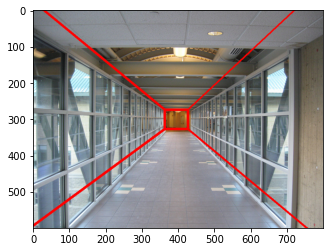

In [61]:
%matplotlib inline
display = display_box(coords, img)

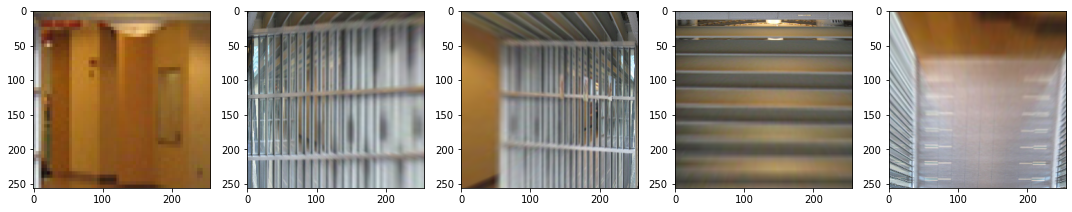

In [63]:
coords3D, x_multiplier, depth = construct(coords, 'results/3', img, 1000)